# **Twitter Sentiment Analysis**

With all of the tweets circulating every second it is hard to tell whether the sentiment behind a specific tweet will impact a company, or a person's, brand for being viral (positive), or devastate profit because it strikes a negative tone. Capturing sentiment in language is important in these times where decisions and reactions are created and updated in seconds.In this project I'll predict the words which actually lead to the sentiment description. 

**Dataset:**

Each row contains the text of a tweet and a sentiment label. In the training set you are provided with a word or phrase drawn from the tweet (selected_text) that encapsulates the provided sentiment.

**Target:**

To predict the word or phrase from the tweet that exemplifies the provided sentiment. The word or phrase should include all characters within that span (i.e. including commas, spaces, etc.)

**Approach:**
Exploratory Data Analysis by Generating Meta Features and calculating Jaccard Similarity scores. Modeling using Named Entity Recognition(NER)



# **Importing Necessary Libraries and Modules**

In [ ]:
#pip install --upgrade plotly

In [ ]:
import re
import string
import numpy as np
import random
import pandas as pd

#For data visualisation
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff

from collections import Counter 

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

#For NLP
import nltk
from nltk.corpus import stopwords

from tqdm import tqdm
import os
import nltk
import spacy
import random
from spacy.util import compounding
from spacy.util import minibatch

import warnings
warnings.filterwarnings("ignore")

#import os
#for dirname, _, filenames in os.walk(''):
#  for filename in filenames:
#    print(os.path.join(dirname, filename))

#Any results you write to the current directory are saved as output.

**Creating helper Function**

In [ ]:
#helper Function to generate random colors used to give different colors to plots.
def random_colours(number_of_colors):
  colors=[]
  for i in range(number_of_colors):
    colors.append("#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]))
  return colors


# **Loading the Data**

In [ ]:
train=pd.read_csv('/content/drive/My Drive/ML Projects datasets/Twitter Sentiment Analysis/train.csv')
test=pd.read_csv('/content/drive/My Drive/ML Projects datasets/Twitter Sentiment Analysis/test.csv')
ss=pd.read_csv('/content/drive/My Drive/ML Projects datasets/Twitter Sentiment Analysis/sample_submission.csv')

In [ ]:
print(train.shape)
print(test.shape)

(27481, 4)
(3534, 3)


**Filling missing values**

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


we have one null value in the train, as the text field for value is NAN.

In [ ]:
#dropping row with null value
train.dropna(inplace=True)

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27480 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27480 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27480 non-null  object
dtypes: object(4)
memory usage: 1.0+ MB


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3534 entries, 0 to 3533
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   textID     3534 non-null   object
 1   text       3534 non-null   object
 2   sentiment  3534 non-null   object
dtypes: object(3)
memory usage: 83.0+ KB


test set contains no null value

# **Exploratory Data Analysis**

In [ ]:
train.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [ ]:
train.describe()

,textID,text,selected_text,sentiment
count,27480,27480,27480,27480
unique,27480,27480,22463,3
top,5236d69815,"dude, that`s eff`ed up. LOL @ chris browning ...",good,neutral
freq,1,1,199,11117


**Analysing distribution of tweets**

In [ ]:
temp=train.groupby('sentiment').count()['text'].reset_index().sort_values(by='text',ascending=False)
temp.style.background_gradient(cmap='Purples')

,sentiment,text
1,neutral,11117
2,positive,8582
0,negative,7781


In [ ]:
#Funnel Chart for sentiments
fig=go.Figure(go.Funnelarea(
    text=temp.sentiment,
    values=temp.text,
    title={"position":"top center","text":"Funnel=Chart of Sentiment Distribution"}
))
fig.show()

Here, it's clear that we have more neutral tweets with almost equal no of negative and positive tweets

# **Generating Meta-Features**

**Jaccard Similarity Scores between text and Selected_text**

In [ ]:
def jaccard(str1,str2):
  a=set(str1.lower().split())
  b=set(str2.lower().split())
  c=a.intersection(b)
  return(float(len(c))/(len(a) + len(b) - len(c)))

In [ ]:
results_jaccard=[]
for ind,row in train.iterrows():
  sentence1=row.text
  sentence2=row.selected_text
  jaccard_score=jaccard(sentence1, sentence2)
  results_jaccard.append([sentence1,sentence2,jaccard_score])

In [ ]:
jaccard=pd.DataFrame(results_jaccard,columns=["text","selected_text","jaccard_score"])
train=train.merge(jaccard,how='outer')

**Difference In Number of words in Selected_text and Text**

In [ ]:
train['Num_words_ST']=train['selected_text'].apply(lambda x:len(str(x).split()))
train['Num_words_text']=train['text'].apply(lambda x:len(str(x).split()))
train['difference_in_words']=train['Num_words_text']-train['Num_words_ST']

In [ ]:
train.head()

,textID,text,selected_text,sentiment,jaccard_score,Num_words_ST,Num_words_text,difference_in_words
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,1.000000,7,7,0
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,0.200000,2,10,8
2,088c60f138,my boss is bullying me...,bullying me,negative,0.166667,2,5,3
3,9642c003ef,what interview! leave me alone,leave me alone,negative,0.600000,3,5,2
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,0.214286,3,14,11


# **Distribution of Meta Features**

**Distribution of Number of words**

In [ ]:
hist_data = [train['Num_words_ST'],train['Num_words_text']]

group_labels = ['Selected_Text', 'Text']

# Create distplot with custom bin_size
fig = ff.create_distplot(hist_data, group_labels,show_curve=False)
fig.update_layout(title_text='Distribution of Number Of words')
fig.update_layout(
    autosize=False,
    width=900,
    height=700,
    paper_bgcolor="LightSteelBlue",
)
fig.show()

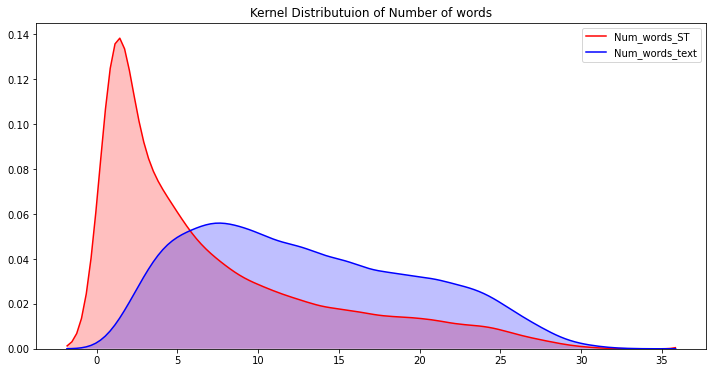

In [ ]:
plt.figure(figsize=(12,6))
p1=sns.kdeplot(train['Num_words_ST'], shade=True, color="r").set_title('Kernel Distributuion of Number of words')
p1=sns.kdeplot(train['Num_words_text'], shade=True, color="b")

**Difference in number of words and jaccard_scores across different Sentiments**

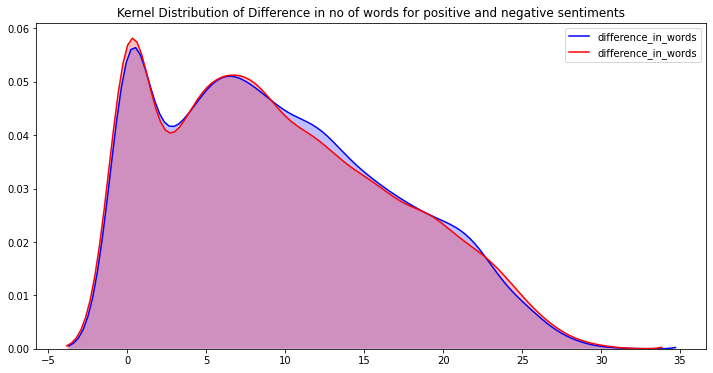

In [ ]:
plt.figure(figsize=(12,6))
p1=sns.kdeplot(train[train['sentiment']=='positive']['difference_in_words'], shade=True, color="b").set_title('Kernel Distribution of Difference in no of words for positive and negative sentiments')
p2=sns.kdeplot(train[train['sentiment']=='negative']['difference_in_words'], shade=True, color="r")

Text(0.5, 1.0, 'Kernel Distribution of Difference in no of words for neutral sentiments')

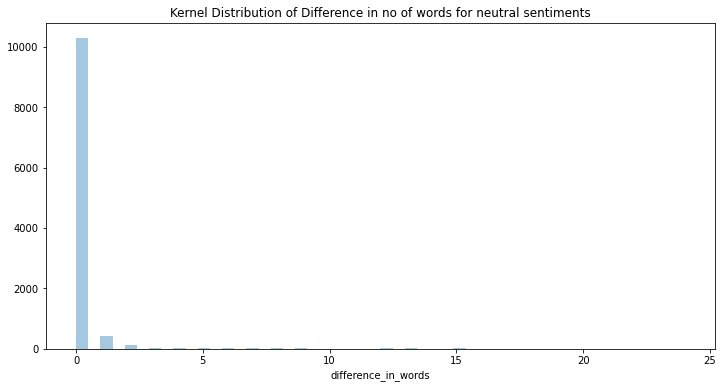

In [ ]:
plt.figure(figsize=(12,6))
sns.distplot(train[train['sentiment']=='neutral']['difference_in_words'],kde=False).set_title('Kernel Distribution of Difference in no of words for neutral sentiments')

**Jaccered Scores across different Sentiments**

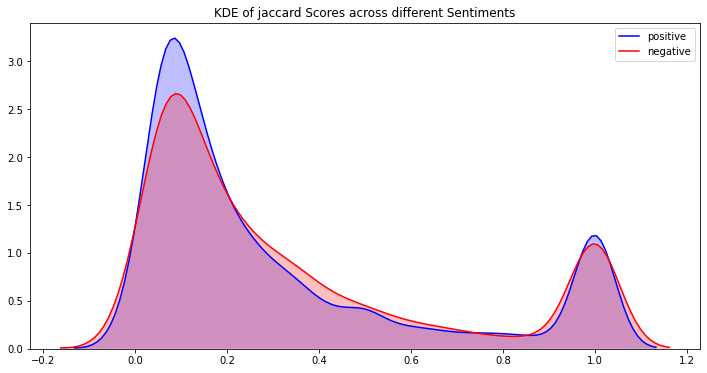

In [ ]:
plt.figure(figsize=(12,6))
p1=sns.kdeplot(train[train['sentiment']=='positive']['jaccard_score'], shade=True, color="b").set_title('KDE of jaccard Scores across different Sentiments')
p2=sns.kdeplot(train[train['sentiment']=='negative']['jaccard_score'],shade=True, color="r")
plt.legend(labels=['positive','negative'])


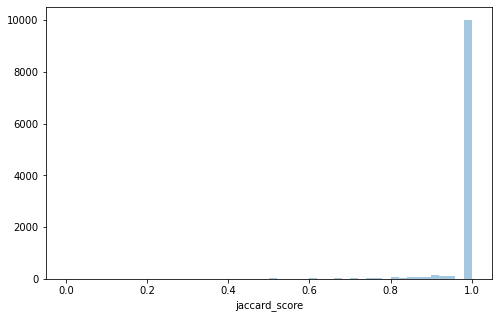

In [ ]:
plt.figure(figsize=(8,5))
sns.distplot(train[train['sentiment']=='neutral']['jaccard_score'],kde=False)

We can see some interesting trends here:

*   Positive and negative tweets have high kurtosis and thus values are concentrated in two regions narrow and high density
*   Neutral tweets have a low kurtosis value and their is bump in density near values of 1



In [ ]:
#Kurtosis is the measure of how peaked a distribution is and how much spread it is around that peak
#Skewness measures how much a curve deviates from a normal distribution

# **Conclusion Of EDA**

In [ ]:
k=train[train['Num_words_text']<=2]
k.groupby('sentiment').mean()['jaccard_score']

sentiment
negative    0.788580
neutral     0.977805
positive    0.765700
Name: jaccard_score, dtype: float64

In [ ]:
k[k['sentiment']=='positive']

,textID,text,selected_text,sentiment,jaccard_score,Num_words_ST,Num_words_text,difference_in_words
68,fa2654e730,Chilliin,Chilliin,positive,1.0,1,1,0
80,bbbc46889b,THANK YYYYYYYYYOOOOOOOOOOUUUUU!,THANK YYYYYYYYYOOOOOOOOOOUUUUU!,positive,1.0,2,2,0
170,f3d95b57b1,good morning,good morning,positive,1.0,2,2,0
278,89d5b3f0b5,Thanks,Thanks,positive,1.0,1,1,0
429,a78ef3e0d0,Goodmorning,Goodmorning,positive,1.0,1,1,0
...,...,...,...,...,...,...,...,...
26689,e80c242d6a,Goodnight;,Goodnight;,positive,1.0,1,1,0
26725,aad244f37d,*hug*,*hug*,positive,1.0,1,1,0
26842,a46571fe12,congrats!,congrats!,positive,1.0,1,1,0
26959,49a942e9b1,Happy birthday.,Happy birthday.,positive,1.0,2,2,0


# **Cleaning Data**

In [ ]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [ ]:
train['text']=train['text'].apply(lambda x:clean_text(x))
train['selected_text']=train['selected_text'].apply(lambda x:clean_text(x))


In [ ]:
train.head()

,textID,text,selected_text,sentiment,jaccard_score,Num_words_ST,Num_words_text,difference_in_words
0,cb774db0d1,id have responded if i were going,id have responded if i were going,neutral,1.000000,7,7,0
1,549e992a42,sooo sad i will miss you here in san diego,sooo sad,negative,0.200000,2,10,8
2,088c60f138,my boss is bullying me,bullying me,negative,0.166667,2,5,3
3,9642c003ef,what interview leave me alone,leave me alone,negative,0.600000,3,5,2
4,358bd9e861,sons of why couldnt they put them on the rel...,sons of,negative,0.214286,3,14,11


**Most Common words in our Target-Selected Text**

In [ ]:
train['temp_list']=train['selected_text'].apply(lambda x:str(x).split())
top=Counter([item for sublist in train['temp_list'] for item in sublist])
temp=pd.DataFrame(top.most_common(20))
temp.columns=['Common_words','count']
temp.style.background_gradient(cmap='Blues')

,Common_words,count
0,i,7200
1,to,5305
2,the,4590
3,a,3538
4,my,2783
5,you,2624
6,and,2321
7,it,2158
8,is,2115
9,in,1986


In [ ]:
fig=px.bar(temp, x="count", y="Common_words",title='Most Common Words in Selected Text', orientation='h',width=700, height=700, color='Common_words')
fig.show()

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

**removing stopwords**

In [ ]:
def remove_stopword(x):
  return [y for y in x if y not in stopwords.words('english')]
train['temp_list']=train['temp_list'].apply(lambda x:remove_stopword(x))

In [ ]:
top=Counter([item for sublist in train['temp_list'] for item in sublist])
temp=pd.DataFrame(top.most_common(20))
temp=temp.iloc[1:,:]
temp.columns=['Common_words','count']
temp.style.background_gradient(cmap='Purples')

,Common_words,count
1,good,1251
2,day,1058
3,love,909
4,happy,852
5,like,774
6,get,772
7,dont,765
8,go,700
9,cant,613
10,work,612


**Tree of Most Common Words**

In [ ]:
fig = px.treemap(temp, path=['Common_words'], values='count',title='Tree of Most Common Words')
fig.show()

**Most Common words in Text**

In [ ]:
train['temp_list1'] = train['text'].apply(lambda x:str(x).split()) #List of words in every row for text
train['temp_list1'] = train['temp_list1'].apply(lambda x:remove_stopword(x)) #Removing Stopwords

In [ ]:
top = Counter([item for sublist in train['temp_list1'] for item in sublist])
temp = pd.DataFrame(top.most_common(25))
temp = temp.iloc[1:,:]
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

,Common_words,count
1,day,2044
2,good,1549
3,get,1426
4,like,1346
5,go,1267
6,dont,1200
7,love,1122
8,work,1112
9,going,1096
10,today,1096


In [ ]:
fig = px.bar(temp, x="count", y="Common_words", title='Commmon Words in Text', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

**Most common words SentimentsWise**

In [ ]:
Positive_sent=train[train['sentiment']=='positive']
Negative_sent=train[train['sentiment']=='negative']
Neutral_sent=train[train['sentiment']=='neutral']

In [ ]:
#MosT common positive words
top = Counter([item for sublist in Positive_sent['temp_list'] for item in sublist])
temp_positive = pd.DataFrame(top.most_common(20))
temp_positive.columns = ['Common_words','count']
temp_positive.style.background_gradient(cmap='Greens')

,Common_words,count
0,good,826
1,happy,730
2,love,697
3,day,456
4,thanks,439
5,great,364
6,fun,287
7,nice,267
8,mothers,259
9,hope,245


In [ ]:
fig = px.bar(temp_positive, x="count", y="Common_words", title='Most Commmon Positive Words', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

In [ ]:
#MosT common negative words
top = Counter([item for sublist in Negative_sent['temp_list'] for item in sublist])
temp_negative = pd.DataFrame(top.most_common(20))
temp_negative = temp_negative.iloc[1:,:]
temp_negative.columns = ['Common_words','count']
temp_negative.style.background_gradient(cmap='Reds')

,Common_words,count
1,miss,358
2,sad,343
3,sorry,300
4,bad,246
5,hate,230
6,dont,221
7,cant,201
8,sick,166
9,like,162
10,sucks,159


In [ ]:
fig = px.treemap(temp_negative, path=['Common_words'], values='count',title='Tree Of Most Common Negative Words')
fig.show()

In [ ]:
#MosT common Neutral words
top = Counter([item for sublist in Neutral_sent['temp_list'] for item in sublist])
temp_neutral = pd.DataFrame(top.most_common(20))
temp_neutral = temp_neutral.loc[1:,:]
temp_neutral.columns = ['Common_words','count']
temp_neutral.style.background_gradient(cmap='Reds')

,Common_words,count
1,get,612
2,go,569
3,day,492
4,dont,482
5,going,472
6,work,467
7,like,445
8,got,441
9,today,427
10,lol,427


In [ ]:
fig = px.bar(temp_neutral, x="count", y="Common_words", title='Most Commmon Neutral Words', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

In [ ]:
fig = px.treemap(temp_neutral, path=['Common_words'], values='count',title='Tree Of Most Common Neutral Words')
fig.show()

1. We can see words like get,go,dont,got,u,cant,lol,like are common in all three segments . That's interesting because words like dont and cant are more of negative nature and words like lol are more of positive nature.Does this mean our data is incorrectly labelled , we will have more insights on this after N-gram analysis

2. It will be interesting to see the word unique to different sentiments




**Unique words in each Segment**

In [ ]:
raw_text=[word for word_list in train['temp_list1'] for word in word_list]

In [ ]:
def words_unique(sentiment,numwords,raw_words):
    '''
    Input:
        segment - Segment category (ex. 'Neutral');
        numwords - how many specific words do you want to see in the final result; 
        raw_words - list  for item in train_data[train_data.segments == segments]['temp_list1']:
    Output: 
        dataframe giving information about the name of the specific ingredient and how many times it occurs in the chosen cuisine (in descending order based on their counts)..

    '''
    allother = []
    for item in train[train.sentiment != sentiment]['temp_list1']:
        for word in item:
            allother .append(word)
    allother  = list(set(allother ))
    
    specificnonly = [x for x in raw_text if x not in allother]
    
    mycounter = Counter()
    
    for item in train[train.sentiment == sentiment]['temp_list1']:
        for word in item:
            mycounter[word] += 1
    keep = list(specificnonly)
    
    for word in list(mycounter):
        if word not in keep:
            del mycounter[word]
    
    Unique_words = pd.DataFrame(mycounter.most_common(numwords), columns = ['words','count'])
    
    return Unique_words

**Positive Tweets**

In [ ]:
Unique_Positive=words_unique('positive',20,raw_text)
print("The top 20 unique words in Positive Tweets are:")
Unique_Positive.style.background_gradient(cmap='Greens')

The top 20 unique words in Positive Tweets are:


,words,count
0,congratulations,29
1,thnx,10
2,appreciated,8
3,shared,7
4,presents,7
5,greetings,7
6,blessings,6
7,mothersday,6
8,mcr,6
9,coolest,6


In [ ]:
fig=px.treemap(Unique_Positive,path=['words'],values='count',title='Tree Of Unique Positive Words')
fig.show()

**Negative Tweets**

In [ ]:
Unique_Negative= words_unique('negative', 10, raw_text)
print("The top 10 unique words in Negative Tweets are:")
Unique_Negative.style.background_gradient(cmap='Reds')

The top 10 unique words in Negative Tweets are:


,words,count
0,ache,12
1,suffering,9
2,allergic,7
3,cramps,7
4,saddest,7
5,pissing,7
6,sob,6
7,dealing,6
8,devastated,6
9,noes,6


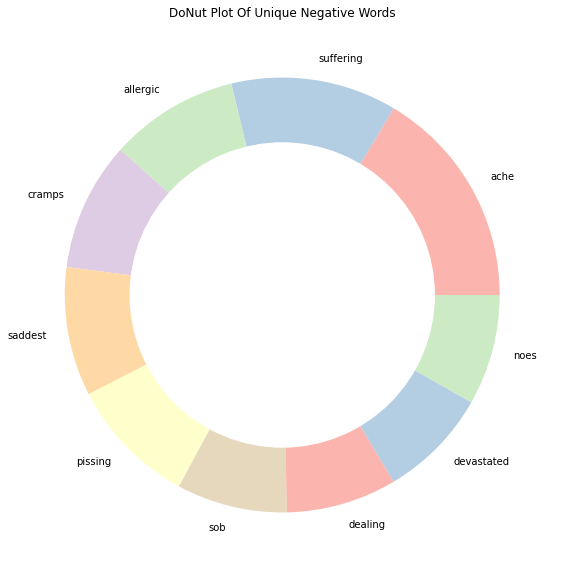

In [ ]:
from palettable.colorbrewer.qualitative import Pastel1_7
plt.figure(figsize=(16,10))
my_circle=plt.Circle((0,0), 0.7, color='white')
plt.rcParams['text.color'] = 'black'
plt.pie(Unique_Negative['count'], labels=Unique_Negative.words, colors=Pastel1_7.hex_colors)
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title('DoNut Plot Of Unique Negative Words')
plt.show()

In [ ]:
Unique_Neutral= words_unique('neutral', 10, raw_text)
print("The top 10 unique words in Neutral Tweets are:")
Unique_Neutral.style.background_gradient(cmap='Oranges')

The top 10 unique words in Neutral Tweets are:


,words,count
0,settings,9
1,explain,7
2,mite,6
3,hiya,6
4,reader,5
5,pr,5
6,sorta,5
7,fathers,5
8,enterprise,5
9,guessed,5


**WordClouds**

In [ ]:
def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(24.0,16.0), color = 'white',
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    more_stopwords = {'u', "im"}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color=color,
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=400, 
                    height=200,
                    mask = mask)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  
d = '/content/drive/My Drive/ML Projects datasets/Twitter Sentiment Analysis/masks-wordclouds/'

**Neutral Tweets**

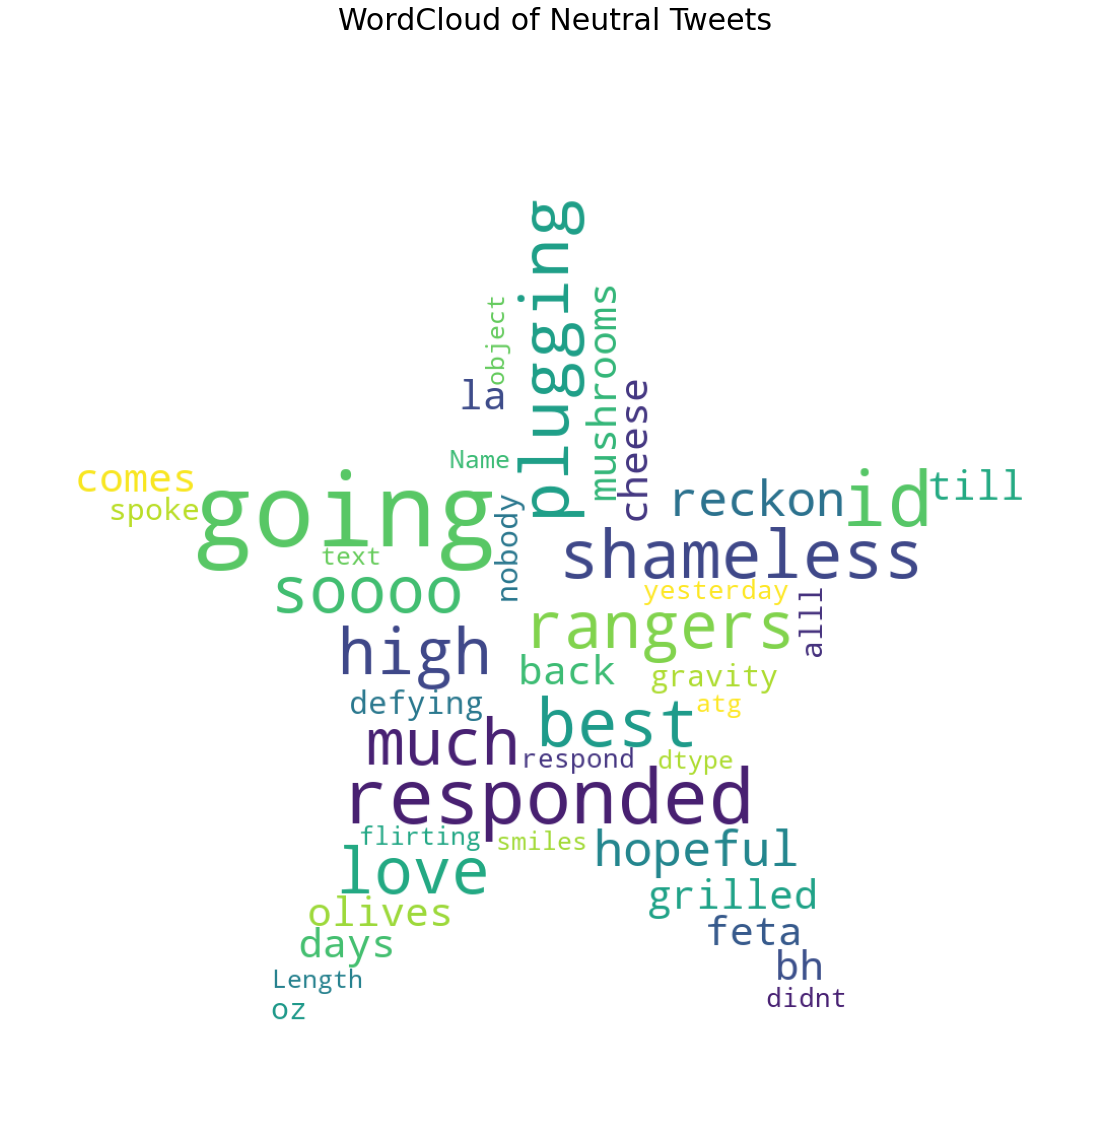

In [ ]:
pos_mask = np.array(Image.open(d+ 'star.png'))
plot_wordcloud(Neutral_sent.text,mask=pos_mask,color='white',max_font_size=100,title_size=30,title="WordCloud of Neutral Tweets")

**Positive Tweets**

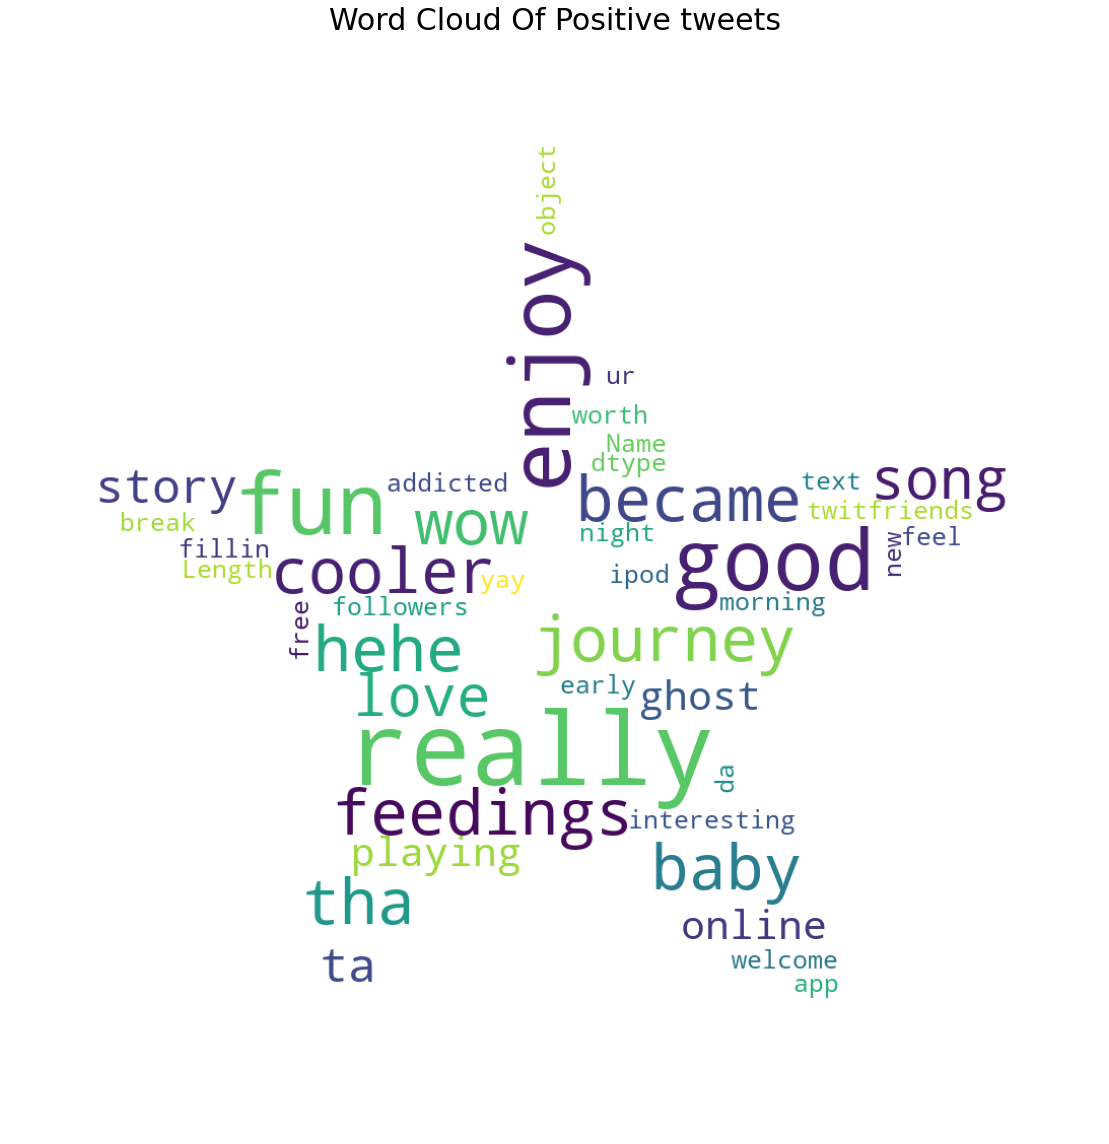

In [ ]:
plot_wordcloud(Positive_sent.text,mask=pos_mask,title="Word Cloud Of Positive tweets",title_size=30)

**Negative Tweets**

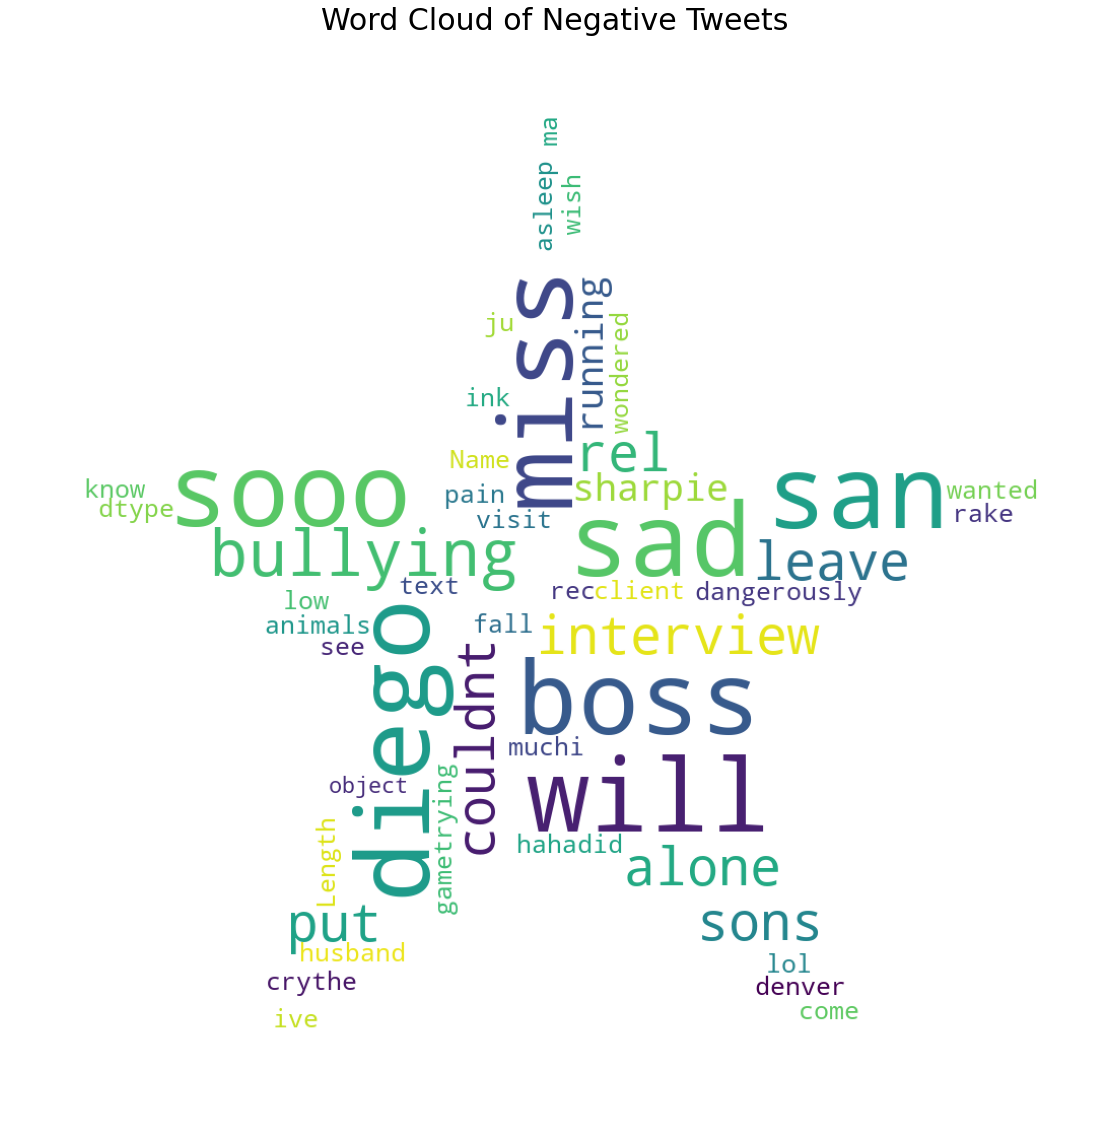

In [ ]:
plot_wordcloud(Negative_sent.text,mask=pos_mask,title="Word Cloud of Negative Tweets",color='white',title_size=30)

# **Modelling**

**Modelling the problem as NER**

Named Entity Recognition (NER) is a standard NLP problem which involves spotting named entities (people, places, organizations etc.) from a chunk of text, and classifying them into a predefined set of categories.

We will be using spacy for creating our own customised NER model or models (seperate for each Sentiment).

approach:
1. using text as selected_text fro all neutral tweets due to their high jaccared similarity.
2. using text as selected_text for all tweets having number of words less than 3 in text.
3. training two different models for Positive and Negtive tweets.
4. no preprocessing of data because the selected text contains raw text

In [ ]:
df_train=pd.read_csv('/content/drive/My Drive/ML Projects datasets/Twitter Sentiment Analysis/train.csv')
df_test=pd.read_csv('/content/drive/My Drive/ML Projects datasets/Twitter Sentiment Analysis/test.csv')
df_submission=pd.read_csv('/content/drive/My Drive/ML Projects datasets/Twitter Sentiment Analysis/sample_submission.csv')

In [ ]:
#Number Of words in main Text in train set
df_train['Num_words_text']=df_train['text'].apply(lambda x:len(str(x).split()))

In [ ]:
df_train=df_train[df_train['Num_words_text']>=3]

**creating necessary functions**

In [ ]:
def save_model(output_dir, nlp, new_model_name):


  ''' This Function Saves model to 
    given output directory'''

  output_dir=f'/content/drive/My Drive/ML Projects datasets/Twitter Sentiment Analysis'
  if output_dir is not None:
    if not os.path.exists(output_dir):
      os.makedirs(output_dir)
    nlp.meta["name"]=new_model_name
    nlp.to_disk(output_dir)
    print("Saved model to",output_dir)  


In [ ]:
# pass model = nlp if you want to train on top of existing model 

def train(train_data, output_dir, n_iter=20, model=None):
    """Load the model, set up the pipeline and train the entity recognizer."""
    ""
    if model is not None:
        nlp = spacy.load(output_dir)  # load existing spaCy model
        print("Loaded model '%s'" % model)
    else:
        nlp = spacy.blank("en")  # create blank Language class
        print("Created blank 'en' model")
    
    # create the built-in pipeline components and add them to the pipeline
    # nlp.create_pipe works for built-ins that are registered with spaCy
    if "ner" not in nlp.pipe_names:
        ner = nlp.create_pipe("ner")
        nlp.add_pipe(ner, last=True)
    # otherwise, get it so we can add labels
    else:
        ner = nlp.get_pipe("ner")
    
    # add labels
    for _, annotations in train_data:
        for ent in annotations.get("entities"):
            ner.add_label(ent[2])

    # get names of other pipes to disable them during training
    other_pipes = [pipe for pipe in nlp.pipe_names if pipe != "ner"]
    with nlp.disable_pipes(*other_pipes):  # only train NER
        # sizes = compounding(1.0, 4.0, 1.001)
        # batch up the examples using spaCy's minibatch
        if model is None:
            nlp.begin_training()
        else:
            nlp.resume_training()


        for itn in tqdm(range(n_iter)):
            random.shuffle(train_data)
            batches = minibatch(train_data, size=compounding(4.0, 500.0, 1.001))    
            losses = {}
            for batch in batches:
                texts, annotations = zip(*batch)
                nlp.update(texts,  # batch of texts
                            annotations,  # batch of annotations
                            drop=0.5,   # dropout - make it harder to memorise data
                            losses=losses, 
                            )
            print("Losses", losses)
    save_model(output_dir, nlp, 'st_ner')


In [ ]:
def get_model_out_path(sentiment):
    '''
    Returns Model output path
    '''
    model_out_path = None
    if sentiment == 'positive':
        model_out_path = '/content/drive/My Drive/ML Projects datasets/Twitter Sentiment Analysis'
    elif sentiment == 'negative':
        model_out_path = '/content/drive/My Drive/ML Projects datasets/Twitter Sentiment Analysis'
    return model_out_path

In [ ]:
def get_training_data(sentiment):
    '''
    Returns Trainong data in the format needed to train spacy NER
    '''
    train_data = []
    for index, row in df_train.iterrows():
        if row.sentiment == sentiment:
            selected_text = row.selected_text
            text = row.text
            start = text.find(selected_text)
            end = start + len(selected_text)
            train_data.append((text, {"entities": [[start, end, 'selected_text']]}))
    return train_data

**Training models for Positive and Negative tweets**

In [ ]:
sentiment='positive'
train_data=get_training_data(sentiment)
model_path=get_model_out_path(sentiment)
train(train_data, model_path, n_iter=3, model=None)


  0%|          | 0/3 [00:00<?, ?it/s]

Created blank 'en' model



 33%|███▎      | 1/3 [00:50<01:41, 50.88s/it]

Losses {'ner': 33824.92269957068}



 67%|██████▋   | 2/3 [01:39<00:50, 50.29s/it]

Losses {'ner': 31637.44057617714}



100%|██████████| 3/3 [02:28<00:00, 49.57s/it]

Losses {'ner': 29882.33191673368}
Saved model to /content/drive/My Drive/ML Projects datasets/Twitter Sentiment Analysis


In [ ]:
sentiment='negative'
train_data=get_training_data(sentiment)
model_path=get_model_out_path(sentiment)
train(train_data, model_path, n_iter=3, model=None)


  0%|          | 0/3 [00:00<?, ?it/s]

Created blank 'en' model



 33%|███▎      | 1/3 [00:46<01:33, 46.61s/it]

Losses {'ner': 31798.840790329035}



 67%|██████▋   | 2/3 [01:33<00:46, 46.67s/it]

Losses {'ner': 28893.18859484204}



100%|██████████| 3/3 [02:19<00:00, 46.65s/it]

Losses {'ner': 26929.6221698059}
Saved model to /content/drive/My Drive/ML Projects datasets/Twitter Sentiment Analysis


**Predicting with the trained Model**

In [ ]:
def predict_entities(text, model):
    doc = model(text)
    ent_array = []
    for ent in doc.ents:
        start = text.find(ent.text)
        end = start + len(ent.text)
        new_int = [start, end, ent.label_]
        if new_int not in ent_array:
            ent_array.append([start, end, ent.label_])
    selected_text = text[ent_array[0][0]: ent_array[0][1]] if len(ent_array) > 0 else text
    return selected_text

In [ ]:
selected_texts = []
MODELS_BASE_PATH = '/content/drive/My Drive/ML Projects datasets/Twitter Sentiment Analysis/models/'

if MODELS_BASE_PATH is not None:
    print("Loading Models  from ", MODELS_BASE_PATH)
    model_pos = spacy.load(MODELS_BASE_PATH + 'model_pos')
    model_neg = spacy.load(MODELS_BASE_PATH + 'model_neg')
        
    for index, row in df_test.iterrows():
        text = row.text
        output_str = ""
        if row.sentiment == 'neutral' or len(text.split()) <= 2:
            selected_texts.append(text)
        elif row.sentiment == 'positive':
            selected_texts.append(predict_entities(text, model_pos))
        else:
            selected_texts.append(predict_entities(text, model_neg))
        
df_test['selected_text'] = selected_texts

Loading Models  from  /content/drive/My Drive/ML Projects datasets/Twitter Sentiment Analysis/models/


In [ ]:
df_submission['selected_text']=df_test['selected_text']
df_submission.to_csv("submission.csv", index=False)
display(df_submission.head(10))

,textID,selected_text
0,f87dea47db,Last session of the day http://twitpic.com/67ezh
1,96d74cb729,exciting
2,eee518ae67,Recession
3,01082688c6,happy bday!
4,33987a8ee5,I like it!!
5,726e501993,visitors!
6,261932614e,HATES
7,afa11da83f,blocked
8,e64208b4ef,and within a short time of the last clue all ...
9,37bcad24ca,What did you get? My day is alright.. haven`...


Here we have the predicted word or phrase from the tweet that exemplifies the provided sentiment. The word or phrase includes all characters within that span (i.e. including commas, spaces, etc.). 